## TODO
rename file folders -- done 
check if differenet image count per class is problem -- 
load the dataset probably -- 
resize images via PIL Image load > convert to torch tensor or directly loading it via torchvision read image --


# Imports


In [221]:
import sys
import hashlib
!{sys.executable} -m pip install torch torchvision matplotlib numpy
from collections import Counter
import shutil

import torch
import numpy as np
#to load the dataset and to split the dataset
from torch.utils.data import DataLoader, random_split
#for resizing of images
from torchvision import transforms
#to read images from path
import random
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [222]:
#simply getting working directory and appending the archive directories to it
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, "archive/raw-img")
print("Dataset directory: ", dataset_dir)

Dataset directory:  /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/raw-img


In [223]:
#experiment, by which i determined that the average size of the images is 250x320 (width x height)so i will would resize it to that size but working with width=height is easier so the size would be 250x250, but from presentation of CNN we learned that resizing them to 224x224 could be better
# average_height = 0
# average_width = 0
# images_count = 0
# for file_name in os.listdir(dataset_dir):
#     if not os.path.isdir(os.path.join(dataset_dir, file_name)):
#         continue # Not a directory
#     class_dir = os.path.join(dataset_dir, file_name)
#     for class_file_name in os.listdir(class_dir):
#         img_size = Image.open(os.path.join(class_dir, class_file_name)).size
#         average_width += img_size[0]
#         average_height += img_size[1]
#         images_count += 1
#     print(file_name, "avrHei", average_height/images_count, "avrWid:", average_width/images_count)

# average_height = 0
# average_width = 0
# images_count = 0

#second experiment to see how the image can be converted and worked on with Image nad pytorch tensor transformation
# torch_img_size = (224, 224)
# img_path = os.path.join(dataset_dir, "butterfly")
# listDir = os.listdir(img_path)
# img_name = listDir[0]
# img_path = os.path.join(img_path, img_name)
# #toto nacita obrazok 
# torchImage = read_image(img_path) / 255.0

# second_torch_image = transform(torchImage)


In [224]:
#size of the image that will be after "normalization" (setting all the images to the same size)
img_size = (224, 224)
#transormation that will be used on every image https://docs.pytorch.org/vision/stable/transforms.html
image_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
    ])
analysis_transform = transforms.ToTensor()

#loading the dataset with pytorch using ImageFolder https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

image_dataset = ImageFolder(
    root = dataset_dir, 
    transform = image_transform 
)



#if you see ragno, my translate_names.py is not working correctly xd (its spider)
print("Dataset classes: ", image_dataset.classes)

#splitting the dataset to 70% train, 10% validation and 20% train using random_split   https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split

dataset_size = len(image_dataset)
print("Dataset Size:\t", dataset_size)
train_size = int(0.7 * dataset_size)
validation_size   = int(0.1 * dataset_size)
test_size  = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(image_dataset, [train_size, validation_size, test_size])
print("Split sizes:\nTrain:\t\t", len(train_dataset), "\nValidation:\t", len(validation_dataset), "\nTest:\t\t", len(test_dataset))


Dataset classes:  ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Dataset Size:	 26179
Split sizes:
Train:		 18325 
Validation:	 2617 
Test:		 5237


In [225]:
#loading the image_dataset to dataLoader https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True, #this shuffles order of images each epoch, random_split randomizes it only once, maybe we dont need this
    batch_size = 10  #1 is default, maybe experiment with this later
)
validation_loader = DataLoader(
    dataset = validation_dataset,
    shuffle = True,
    batch_size = 10  
)
test_loader = DataLoader(
    dataset = test_dataset,
    shuffle = True,
    batch_size = 10  
)

#this is how we can iterate through the DataLoader
for image_tensor, labels in train_loader:
    #shape is [Batch_size, Channels, Height, Width]
    print(image_tensor.shape)
    #and label (correct class of the image) for each image in tensor (images)
    print(labels) 
    break

torch.Size([10, 3, 224, 224])
tensor([3, 2, 9, 4, 8, 2, 7, 4, 3, 1])


In [226]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider",
}


def rename_dirs(base_path: str):
    for fn in os.listdir(base_path):
        full = os.path.join(base_path, fn)

        if not os.path.isdir(full):
            continue
        if fn not in translate:
            continue

        new_name = translate[fn]
        print(f"{fn}  ->  {new_name}")
        os.rename(full, os.path.join(base_path, new_name))


def show_sample_images(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img, label = dataset[idx] 
        if hasattr(img, "permute"):
            img = img.permute(1, 2, 0).numpy()

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Classes Count: 10

Images per class:
butterfly: 2112
cat: 1668
chicken: 3098
cow: 1866
dog: 4863
elephant: 1446
horse: 2623
sheep: 1820
spider: 4821
squirrel: 1862


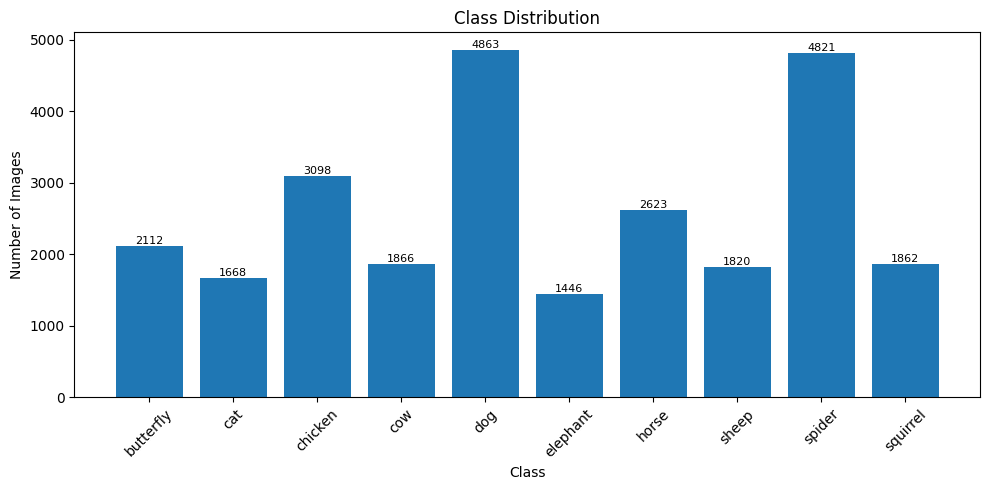

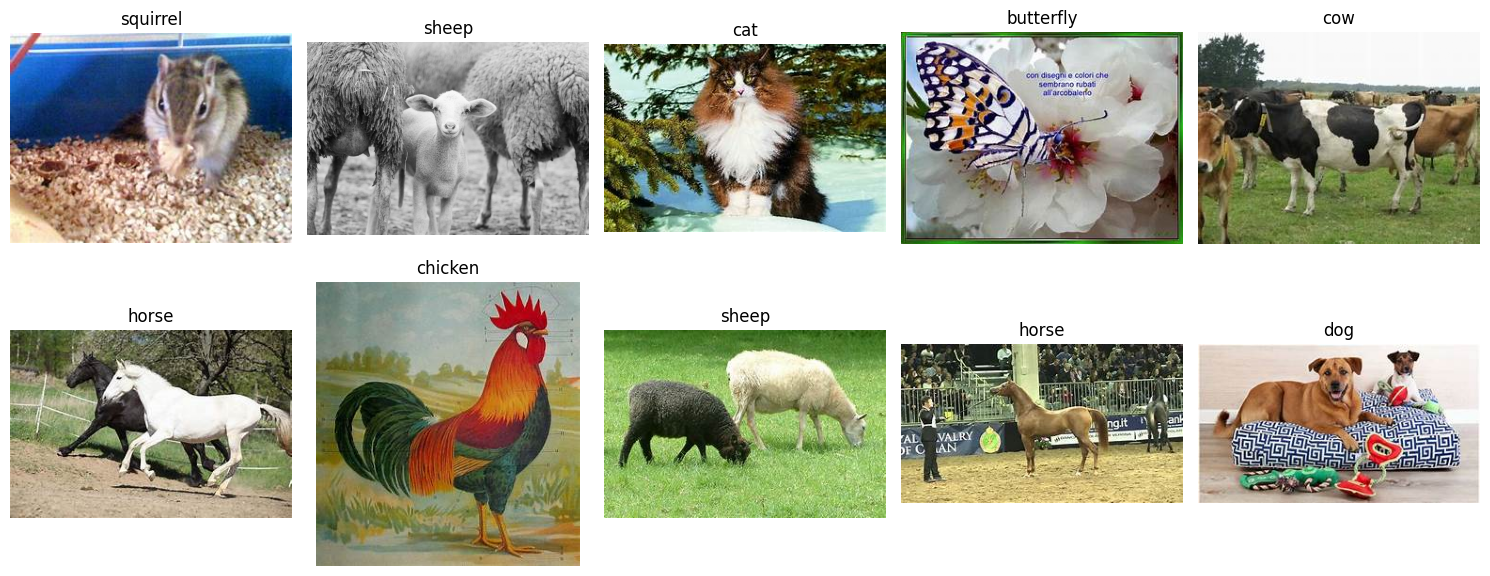

Images size statistics:
Mean width:  320.04
Mean height: 252.63
Min width:   60,  Max width:   6720
Min height:  57, Max height:  6000


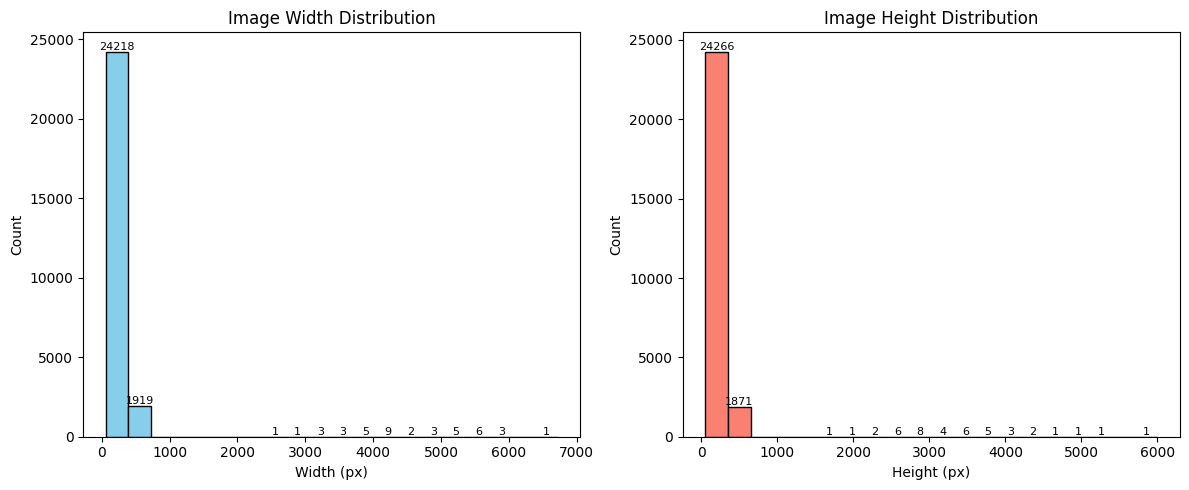

Smallest Image:
Size: 60x57
Path: /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/raw-img/horse/OIP-4UmK-NKWl1fwEK9GfBSGKAAAAA.jpeg

Largest Image:
Size: 6720x4480
Path: /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/raw-img/cat/max-boettinger-486490-unsplash.jpg


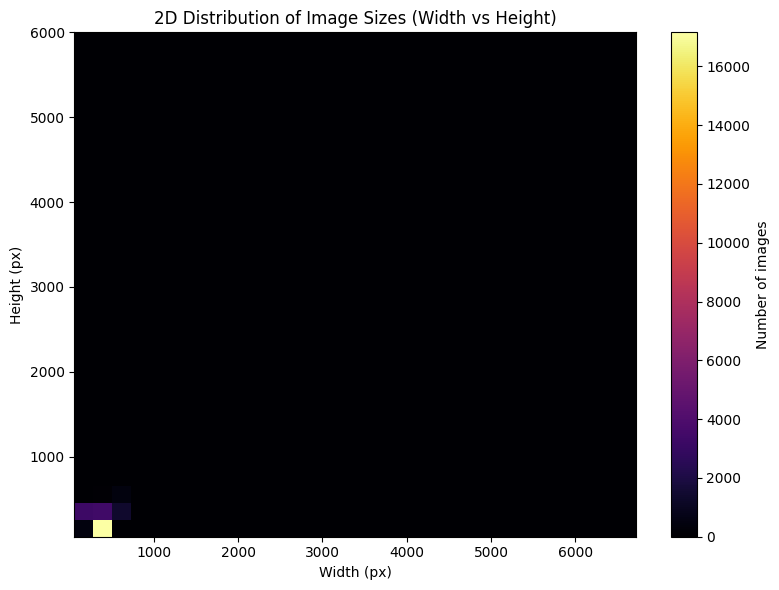

In [227]:
# data anylisis here >
# loading dataset for data vizualization and analysis
rename_dirs(dataset_dir)

analysis_dataset = ImageFolder(root=dataset_dir, transform=analysis_transform)
analysis_loader = DataLoader(dataset=analysis_dataset, shuffle=True, batch_size=10)

print("Classes:", analysis_dataset.classes)
print("Classes Count:", len(analysis_dataset.classes))

counts = Counter([label for _, label in analysis_dataset.samples])

print("\nImages per class:")
for idx, cls_name in enumerate(analysis_dataset.classes):
    print(f"{cls_name}: {counts[idx]}")

plt.figure(figsize=(10, 5))
values = [counts[i] for i in range(len(analysis_dataset.classes))]
bars = plt.bar(analysis_dataset.classes, values)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        str(int(value)),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

show_sample_images(analysis_dataset, num_images=10)


paths = [path for (path, _) in analysis_dataset.samples]

widths = []
heights = []

for p in paths:
    with Image.open(p) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

print("Images size statistics:")
print(f"Mean width:  {widths.mean():.2f}")
print(f"Mean height: {heights.mean():.2f}")
print(f"Min width:   {widths.min()},  Max width:   {widths.max()}")
print(f"Min height:  {heights.min()}, Max height:  {heights.max()}")

plt.figure(figsize=(12, 5))

# Width distribution histogram
plt.subplot(1, 2, 1)
counts_w, bins_w, patches_w = plt.hist(
    widths, bins=20, color="skyblue", edgecolor="black"
)
plt.title("Image Width Distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")

# Titles above bars
for count, patch in zip(counts_w, patches_w):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# Height distribution histogram
plt.subplot(1, 2, 2)
counts_h, bins_h, patches_h = plt.hist(
    heights, bins=20, color="salmon", edgecolor="black"
)
plt.title("Image Height Distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")

for count, patch in zip(counts_h, patches_h):
    if count > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.tight_layout()
plt.show()


sizes = []

for path, _ in analysis_dataset.samples:
    with Image.open(path) as img:
        w, h = img.size
        sizes.append((w, h, path))


min_size = min(sizes, key=lambda x: x[0] * x[1])
max_size = max(sizes, key=lambda x: x[0] * x[1])

print("Smallest Image:")
print(f"Size: {min_size[0]}x{min_size[1]}")
print(f"Path: {min_size[2]}")
print()

print("Largest Image:")
print(f"Size: {max_size[0]}x{max_size[1]}")
print(f"Path: {max_size[2]}")

plt.figure(figsize=(8, 6))

plt.hist2d(widths, heights, bins=30, cmap="inferno")
plt.colorbar(label="Number of images")

plt.title("2D Distribution of Image Sizes (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")

plt.tight_layout()
plt.show()

In [ ]:
# Data Preparation

broken_images = []

for img_path, _ in analysis_dataset.samples:
    try:
        with Image.open(img_path) as img:
            img.verify()
        with Image.open(img_path) as img:
            img.load()
    except Exception as err:
        broken_images.append((img_path, str(err)))

print("Broken or unreadable images found:", len(broken_images))

for img_path, err in broken_images:
    print(f"\nCorrupted file: {img_path}")
    print("Error:", err)

for img_path, _ in broken_images:
    if os.path.exists(img_path):
        os.remove(img_path)
        print("Removed:", img_path)


# Duplicates remove

hash_map = {}
duplicate_groups = []


def calc_image_hash(path):
    with Image.open(path) as img:
        arr = np.array(img)
        return hashlib.md5(arr.tobytes()).hexdigest()


for img_path, _ in analysis_dataset.samples:
    h = calc_image_hash(img_path)
    if h not in hash_map:
        hash_map[h] = [img_path]
    else:
        hash_map[h].append(img_path)

for h, paths in hash_map.items():
    if len(paths) > 1:
        duplicate_groups.append(paths)

print("Pixel-identical duplicate groups found:", len(duplicate_groups))

for i, group in enumerate(duplicate_groups, start=1):
    print(f"\nDuplicate group {i}:")
    for p in group:
        print(" -", p)

for group in duplicate_groups:
    for img_path in group[1:]:
        os.remove(img_path)
        print("Removed:", img_path)

Broken or unreadable images found: 0
Pixel-identical duplicate groups found: 0


In [229]:
# Split dataset into train, val, test folders
random.seed(42)

raw_dir = dataset_dir
base_dir = os.path.dirname(raw_dir)

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_ratio = 0.70
val_ratio = 0.10
test_ratio = 0.20

valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

for cls_name in os.listdir(raw_dir):
    cls_path = os.path.join(raw_dir, cls_name)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_ext)]

    if not files:
        continue

    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_files = files[:n_train]
    val_files = files[n_train : n_train + n_val]
    test_files = files[n_train + n_val :]

    train_cls_dir = os.path.join(train_dir, cls_name)
    val_cls_dir = os.path.join(val_dir, cls_name)
    test_cls_dir = os.path.join(test_dir, cls_name)

    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for fname in train_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(train_cls_dir, fname))

    for fname in val_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(val_cls_dir, fname))

    for fname in test_files:
        shutil.copy2(os.path.join(cls_path, fname), os.path.join(test_cls_dir, fname))

    print(f"{cls_name}: {n_train} train | {n_val} val | {n_test} test")

print("\nNew split complete:")
print("Train:", train_dir)
print("Val:  ", val_dir)
print("Test: ", test_dir)

cat: 1167 train | 166 val | 335 test
butterfly: 1478 train | 211 val | 423 test
dog: 3404 train | 486 val | 973 test
sheep: 1274 train | 182 val | 364 test
spider: 3374 train | 482 val | 965 test
chicken: 2168 train | 309 val | 621 test
horse: 1836 train | 262 val | 525 test
squirrel: 1303 train | 186 val | 373 test
cow: 1306 train | 186 val | 374 test
elephant: 1012 train | 144 val | 290 test

New split complete:
Train: /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/train
Val:   /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/val
Test:  /Users/alexeybelyaev/Desktop/university/zneus_FIIT_Images/archive/test


In [230]:

train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")

preprocess_basic = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

train_raw = ImageFolder(train_path, transform=preprocess_basic)

train_raw_loader = DataLoader(dataset=train_raw, batch_size=64, shuffle=False)

pixel_sum = torch.zeros(3)
pixel_sq_sum = torch.zeros(3)
total_pixels = 0

for batch_images, _ in train_raw_loader:
    batch_size, channels, height, width = batch_images.shape
    num_pixels = batch_size * height * width
    total_pixels += num_pixels

    pixel_sum += batch_images.sum(dim=[0, 2, 3])
    pixel_sq_sum += (batch_images**2).sum(dim=[0, 2, 3])

mean = pixel_sum / total_pixels
std = torch.sqrt(pixel_sq_sum / total_pixels - mean**2)

print("Train Normalization Stats:")
print("Mean:", mean.tolist())
print("Std: ", std.tolist())

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_set = ImageFolder(train_path, transform=train_transforms)
val_set = ImageFolder(val_path, transform=val_transforms)
test_set = ImageFolder(test_path, transform=test_transforms)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print("\nData Preparation finished!")
print("Train samples:", len(train_set))
print("Val samples:  ", len(val_set))
print("Test samples: ", len(test_set))

Train Normalization Stats:
Mean: [0.5183821320533752, 0.5005810856819153, 0.41270580887794495]
Std:  [0.26625004410743713, 0.2612389028072357, 0.2786683440208435]

Data Preparation finished!
Train samples: 18322
Val samples:   2614
Test samples:  5243
